# Neural & Behavioral Modeling - Week 1 (Exercises)
by Cheng-Kuang Wu (r10922186@ntu.edu.tw)

In [2]:
%config IPCompleter.greedy=True 
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import *
from tqdm import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g3g8_1ch because the default path (/home/ckwu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## 1 Party Simulation (5 points)
This is a model of a cocktail party. The men and women at the party form groups. A party-goer becomes uncomfortable and switches groups if their current group has too many members of the opposite sex.

### 1.1 Insert your codes to complete the simulation (2 points)

100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


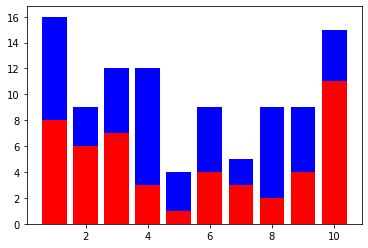

In [12]:
# Supporting functions:
class Person:
    def __init__(self, Ngroups):
        self.sex = np.random.randint(2) # 0: woman; 1: man
        self.Ngroups = Ngroups
        self.group = np.random.randint(Ngroups) # staying in which group?
        
    def leave(self):
        options = np.delete(np.arange(self.Ngroups), self.group) # except the current group
        self.group = int(np.random.choice(options, 1)) # choosing a new group

def plot_party(counts):
    x = np.arange(len(counts)) + 1 # number of groups
    plt.clf() # clear previous figure
    plt.bar(x, counts[:, 0], color='r') # women
    plt.bar(x, counts[:, 1], color='b', bottom=counts[:, 0]) # men on top of women in the plot
    display(plt.gcf()); clear_output(wait=True) # to allow dynamic plots

class PartySimulator(object):

    def __init__(
        self,
        Ngroups: int,
        Npeople: int,
        Tolerance: float
    ):
        self.Ngroups = Ngroups
        self.Npeople = Npeople
        self.Tolerance = Tolerance
    
    def initialize(self):
        self.people = [Person(self.Ngroups) for _ in range(self.Npeople)]
    
    def simulate(self, plot: bool) -> tuple:
        Nhappies = list() # NOTE: keep track of number of happy people
        Psingle_sex_groups = list() # NOTE: record proportion of single sex groups

        # NOTE: A do-while loop
        counts, proportions, Nhappy, Psingle_sex_group, happy_matrix = self.party_stats() # NOTE: the initial party stats
        Nhappies.append(Nhappy)
        Psingle_sex_groups.append(Psingle_sex_group)
        if plot:
            plot_party(counts)

        while (Nhappy < self.Npeople):  # Simulation stops when everyone is happy
            # NOTE: move the people simultaneously (virtually)
            for person in self.people:
                is_not_happy = ~happy_matrix[person.group, person.sex]
                if is_not_happy:
                    person.leave()
            
            # NOTE: update party stats
            counts, proportions, Nhappy, Psingle_sex_group, happy_matrix = self.party_stats()
            # NOTE: record intermediate party stats
            Nhappies.append(Nhappy)
            Psingle_sex_groups.append(Psingle_sex_group)
            
            # Plot new results:
            if plot:
                plot_party(counts)

        return Nhappies, Psingle_sex_groups
    
    def run(self, times: int = 1) -> dict:
        if times < 1:
            raise ValueError("The number of simulations must be at least 1.")

        Nhappies_l = list()
        Psingle_sex_groups_l = list()
        print(f"Running {times} time(s) of simulation(s)... ((Ngroups, Npeople, Tolerance) = ({self.Ngroups}, {self.Npeople}, {self.Tolerance}))")
        for _ in tqdm(range(times)):
            self.initialize()
            Nhappies, Psingle_sex_groups = self.simulate(plot=(times == 1)) # NOTE: do not plot when running multiple simulations
            # NOTE: record simulation results
            Nhappies_l.append(Nhappies)
            Psingle_sex_groups_l.append(Psingle_sex_groups)

        simulation_results = {
            "Nhappies_l": Nhappies_l,
            "Psingle_sex_groups_l": Psingle_sex_groups_l
        }
        return simulation_results

    def party_stats(self) -> tuple: # NOTE: calculate party stats  
        sexes = [self.people[i].sex for i in range(self.Npeople)]
        groups = [self.people[i].group for i in range(self.Npeople)]
        counts = np.zeros((max(groups) + 1, max(sexes) + 1))
        proportions = counts.copy()
        for p in range(self.Npeople):
            counts[groups[p], sexes[p]] += 1
        men_plus_women = np.sum(counts, axis=1) # number of men and women in each group
        men_plus_women[men_plus_women == 0] = np.inf # to avoid "dividing by zeros later
        proportions[:, 0] = counts[:, 0] / men_plus_women # proportion of women in each group
        proportions[:, 1] = counts[:, 1] / men_plus_women # proportion of men in each group

        happy_matrix = proportions >= (1 - self.Tolerance) # NOTE: check for each group if there is a group whose proportion >= (1 - tolerance) i.e. proportion of the opposite sex <= tolerance
        Nhappy = int(counts[happy_matrix].sum()) # NOTE: calculate number of happy people
        Psingle_sex_group = int((proportions == 1.0).any(axis=1).sum()) / int((proportions > 0.0).any(axis=1).sum()) # NOTE: calculate the proportion of single sex groups
        return counts, proportions, Nhappy, Psingle_sex_group, happy_matrix


party_simulator = PartySimulator(Ngroups=10, Npeople=100, Tolerance=1.0)
simulation_results = party_simulator.run()

### 1.2 Modify the three model parameters & discuss how each affects your simulations (2 points)

There are mainly two things I would like to know about under different model parameter settings:

1. How fast (i.e., how many steps are required) will the system reach equilibrium?
2. The degree of group polarization (i.e., the proportion of single sex groups) when the equilibrium is reached.

In the following experiments, simulations will be performed 100 times for each model parameter setting. The simulation results are then analyzed to answer the two questions.

#### Utility Function

In [5]:
# NOTE: utility function for getting the "average number of steps" and "average proportion of group polarization" for multiple simulations
def get_simulation_stats(simulation_results: dict) -> tuple:
    nsteps = list()
    pgroup_props = list()
    
    Psingle_sex_groups_l = simulation_results["Psingle_sex_groups_l"]
    for Psingle_sex_groups in Psingle_sex_groups_l:
        nstep = len(Psingle_sex_groups)
        pgroup_prop = Psingle_sex_groups[-1]
        
        nsteps.append(nstep)
        pgroup_props.append(pgroup_prop)

    avg_nstep = np.array(nsteps).mean()
    avg_pgroup_prop = np.array(pgroup_props).mean()
    return avg_nstep, avg_pgroup_prop

#### 1.2.1 Number of Groups (Ngroups) & Number of People (Npeople)

To study the effect of Ngroups and Npeople, grid search is performed for different parameter settings of (Ngroup, Npeople) under the same Tolerance level of 0.25.

In [ ]:
# NOTE: model parameters
Ngroups_l = [5, 10, 20]
Npeople_l = [25, 50, 100]
Tolerance = 0.25
# NOTE: number of simulations for each parameter setting
nsimulations = 100

# NOTE: initialize empty DataFrames for storing average values of "number of steps" and "proportion of single sex groups" calculated from 100 simulations
dfs = {
    "avg_nstep": pd.DataFrame(data=np.zeros(shape=(len(Ngroups_l), len(Npeople_l))), index=Ngroups_l, columns=Npeople_l, dtype=np.float64),
    "avg_pgroup_prop": pd.DataFrame(data=np.zeros(shape=(len(Ngroups_l), len(Npeople_l))), index=Ngroups_l, columns=Npeople_l, dtype=np.float64)
}
# Name the index and column for each DataFrame
for df in dfs.values():
    df.index.name = "Ngroups"
    df.columns.name = "Npeople"

# Run simulations and fill the values into the DataFrames
for Ngroups in Ngroups_l:
    for Npeople in Npeople_l:
        party_simulator = PartySimulator(Ngroups=Ngroups, Npeople=Npeople, Tolerance=Tolerance)
        simulation_results = party_simulator.run(times=nsimulations)
        avg_nstep, avg_pgroup_prop = get_simulation_stats(simulation_results)

        dfs["avg_nstep"].at[Ngroups, Npeople] = avg_nstep
        dfs["avg_pgroup_prop"].at[Ngroups, Npeople] = avg_pgroup_prop

##### Table 1. Average number of steps under different (Ngroups, Npeople) settings

From this table one can observe two things:

1. Under the same number of groups, more steps are required to reach equilibrium if there are more people.
2. Under the same number of people, less steps are required to reach equilibrium if there are more groups.

Informally speaking, if the system is more "crowded", it would reach equilibrium slower; if the system is less "crowded", it would reach equilibrium faster.

In [7]:
dfs["avg_nstep"]

Npeople,25,50,100
Ngroups,,,
5,9.26,14.90,81.11
10,7.35,9.74,14.67
20,6.07,8.84,11.63


##### Table 2. Average proportion of single sex groups under different (Ngroups, Npeople) settings

From this table one can observe that different (Ngroups, Npeople) settings wouldn't affect the proportion of single sex groups when the Tolerance is set to 0.25.
At such Tolerance level, all groups are polarized (i.e., all groups are single sex groups) when the equilibrium is reached.

In [8]:
dfs["avg_pgroup_prop"]

Npeople,25,50,100
Ngroups,,,
5,1.0,1.0,1.0
10,1.0,1.0,1.0
20,1.0,1.0,1.0


#### 1.2.2 Effects of Tolerance

To study the effect of Tolerance, (Ngroups, Npeople) is set to (10, 100) and simulations are performed under different Tolerance settings.

In [ ]:
# NOTE: model parameters
Ngroups = 10
Npeople = 100
Tolerances = [0.25, 0.35, 0.49, 0.50, 0.60, 0.75, 0.90]
# NOTE: number of simulations for each parameter setting
nsimulations = 100

# NOTE: initialize an empty DataFrame for storing average values of "number of steps" and "proportion of single sex groups" calculated from 100 simulations
tdf = pd.DataFrame(data=np.zeros(shape=(2, len(Tolerances))), index=["nstep", "pgroup_prop"], columns=Tolerances, dtype=np.float64)
# Name the index and column
tdf.index.name = "Average values"
tdf.columns.name = "Tolerance"

# Run simulations and fill the values into the DataFrames
for Tolerance in Tolerances:
    party_simulator = PartySimulator(Ngroups=Ngroups, Npeople=Npeople, Tolerance=Tolerance)
    simulation_results = party_simulator.run(times=nsimulations)
    avg_nstep, avg_pgroup_prop = get_simulation_stats(simulation_results)

    tdf.at["nstep", Tolerance] = avg_nstep
    tdf.at["pgroup_prop", Tolerance] = avg_pgroup_prop

##### Table 3. Average number of steps and average proportion of single sex groups under different Tolerance settings

From this table we can see that:

1. The system reach equilibrium faster (with fewer steps) as Tolerance gets higher.
2. The groups are fully polarized when Tolerance is less than 0.50.
3. The groups become less polarized when Tolerance is greater than or equal to 0.50.

In [16]:
tdf

Tolerance,0.25,0.35,0.49,0.50,0.60,0.75,0.90
Average values,,,,,,,
nstep,15.38,9.13,8.3,7.890,4.980,1.740,1.050
pgroup_prop,1.00,1.00,1.0,0.993,0.611,0.115,0.015


### 1.3 Discuss why the simulaiton leads to group polarization (1 point)

Let's first define some terminology and rules for the convenience of discussion:

* The sets of male and female group members of the $i$-th group are denoted as $A_i$ and $B_i$, respectively.
* The proportion of group members in the $i$-th group is denoted as $N(S_i), S_i \in \{A_i, B_i\}$. For convenience, we define $N(A_i) = 0$ and $N(B_i) = 0$ if there are no group members in the $i$-th group.
* In the case where $N(A_i) \neq 0$ or $N(B_i) \neq 0$, we define $N(A_i) = \frac{N(A_i)}{N(A_i) + N(B_i)}$ and $N(B_i) = \frac{N(B_i)}{N(A_i) + N(B_i)}$.
* For a given tolerance level $T \in \left[0, 1\right]$, a group member will ***leave*** the group and go to other groups randomly if the proportion of the opposite sex is greater than $T$.
* A group is ***unstable*** if any member would ***leave*** the group. On the other hand, a group is ***stable*** if no one would ***leave*** the group or it is an empty group (i.e., with no group members). 
* The system reaches ***equilibrium*** if and only if all groups are ***stable***.
* A group is ***polarized*** if all group members are of a single sex.

From the somewhat loose definitions above, we can describe an ***unstable*** group mathematically as follows: $\left[(N(A_i) > T)  \land (N(B_i) \neq 0)\right] \lor \left[(N(B_i) > T) \land (N(A_i) \neq 0)\right]$, for any $i$.

A group is ***stable*** if one of the following disjoint conditions hold:

1. $(N(A_i) \neq 0) \land (N(B_i) \neq 0) \land (N(A_i) \leq T) \land  (N(B_i) \leq T)$ (not polarized, non-empty)
2. $(N(A_i) \neq 0) \land (N(B_i) = 0)$ (polarized)
3. $(N(A_i) = 0) \land (N(B_i) \neq 0)$ (polarized)
4. $(N(A_i) = 0) \land (N(B_i) = 0)$ (empty)

We now begin our discussion for different values of $T$:

- $T < 0.5$: If condition 1 is true, then $N(A_i) + N(B_i) < 1$, which contradicts which the fact that $N(A_i) + N(B_i) = \frac{N(A_i)}{N(A_i) + N(B_i)} + \frac{N(B_i)}{N(A_i) + N(B_i)} = 1$ according to our definition. Therefore, condition 1 must be false for any group in the party. Moreover, condition 4 cannot be true for ***all*** the groups if there is at least one person in the party simulation. Therefore, all non-empty groups must suffice condition 2 or 3, which means that all non-empty groups will be ***polarized*** towards a specific sex when the ***equilibrium*** is reached under the constraint that $T < 0.5$.

- $T \geq 0.5$: When tolerance $T$ is greater than or equal to 0.5, condition 1 could be true for a given group. In other words, it is possible that there are one or several ***non-polarized*** groups when the ***equilibrium*** is reached. The proportion of non-polarized groups at equilibrium is dependent on the value of $T$ and the system's stochastic behavior (e.g., initialization of the system and group members' movements).

## 2 Understand Shunting Equation (5 points)

$\frac{dy}{dt}=-Ay+(B-y)*E-(y-C)*I$

### 2.1 Find its equilibrium by analytically solving $dy/dt=0$ (1 point)

In [17]:
# Method 1: Solve the equation by sympy
import sympy as sym

t, A, B, E, C, I = sym.symbols('t, A, B, E, C, I')
y = sym.Function('y')(t)

print("Answer:")
sym.dsolve(-A * y + (B - y) * E - (y - C) * I, y)

Answer:


Eq(y(t), (B*E + C*I)/(A + E + I))

Method 2: Solve the equation by hand

$\frac{dy}{dt} = 0$ 

$-Ay + (B - y) * E - (y - C) * I = 0$

$-(A + E + I) * y = -BE - CI$

Answer:

$y = \frac{BE + CI}{A + E + I}$

### 2.2 Use Euler integration to verify your answer in 2.1 with your own (A, B, C, E, I) constants (2 points)


In [18]:
# Write your simulation codes here

# NOTE: utility function for plotting Euler integration
A, B, C, E, I = 1, 2, -2, 1, 2  # NOTE: arbitrarily set the constants
dt = 0.01

def plot_shunting_eq(y_init: float, dt: float, t_range: np.ndarray):
    y = [y_init]
    for _ in t_range:
        y1 = y[-1]
        y2 = y1 + dt * (-A * y1 + (B - y1) * E - (y1 - C) * I)
        y.append(y2)

    plt.plot(t_range, y[:-1], "ro", markerfacecolor="None")
    equi = (B * E + C * I) / (A + E + I) # NOTE: check equilibrium
    print(f"Starting from y = {y_init}, the equilibrium will be reached at (BE + CI) / (A + E + I) = {equi}, which is compatible with the plot.")

Starting from y = -1, the equilibrium will be reached at (BE + CI) / (A + E + I) = -0.5, which is compatible with the plot.


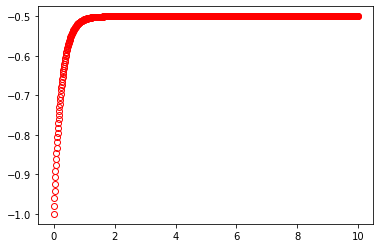

In [19]:
# NOTE: simulate by Euler integration starting from y = -1 (dt = 0.01)
plot_shunting_eq(y_init=-1, dt=dt, t_range=np.arange(0, 10, dt))

Starting from y = 0, the equilibrium will be reached at (BE + CI) / (A + E + I) = -0.5, which is compatible with the plot.


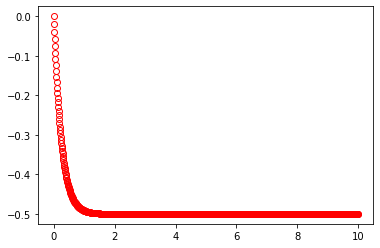

In [20]:
# NOTE: simulate by Euler integration starting from y = 0 (dt = 0.01)
plot_shunting_eq(y_init=0, dt=dt, t_range=np.arange(0, 10, dt))

### 2.3 Combining math & if-then controls in numerical integrations (2 points)

Use Euler integration to plot $dy/dt=-y(t)+E$ where
$E=\begin{cases}
    1  &  \text{if } t<5\\
    0  &  \text{if } t>5
   \end{cases}$
for t=[0,10] & y(t=0)=0.

This is an example of time-varying rather than constant excitation.

#### 2.3.1 Euler Integration

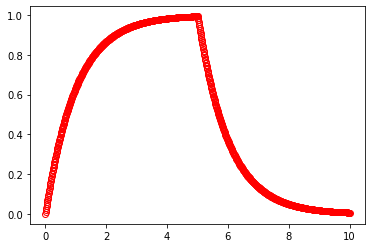

In [21]:
# Write your simulation code here
dt = 0.01
y = [0]
t_range = np.arange(0, 10 + dt, dt) # t = [0, 10]

for t in t_range:
    E = 1 if t < 5 else 0
    y1 = y[-1]
    dy_dt = (-y1 + E) if t != 5 else 0 # NOTE: arbitrarily define dy_dt to be zero when t equals 5 to complete numerical integrations
    y2 = y1 + dt * dy_dt
    y.append(y2)

plt.plot(t_range, y[:-1], "ro", markerfacecolor="None");

## Please submit the HTML version of your notebook to NTU COOL by 9/12(Mon)!